## Reinforcement Learning

> 假设有 10 个广告对人群进行曝光 1万次，点击收 1 元，未点击收 0 元 。广告信息未知，人群信息未知，怎么获得最大收益。

增强学习，也称为 Online Learning.

- 目的：Reinforcement Learning is learning how to act in order to maximum a numerical reward.
- 两种增强学习模型：
    1. Upper Confidence Bound (UCB)
    2. Thompson Sampling

### 1. Upper Confidence Bound(UCB) 置信区间上限算法

#### 1.1 EE 困境和多臂老虎机

EE 困境(Exploration and Exploitation Dilemma), 即探索和利用困境。这个在日常生活中我们经常会遇到一个问题。

例如，我们去美食广场吃饭，会有两种情况出现：

1. 总是去那几家自己满意的餐厅吃饭，这样总会使自己满意，但是这样会错过发现更好的餐厅的机会；
2. 为了发现更好的餐厅，那就一家一家的去试吃，那么这样吃到差餐的概率就会增大；

是继续在已发现的满意的店吃那(Exploitation) 还是接着去探索（Exploration）那? （满意的餐厅也有概率做出不好吃的饭）

Bandit (赌场内的强盗，是赌场内最赚钱的，老虎机）

Multi-armed Bandit, 多臂老虎机问题。赌场内有一组老虎机，每个老虎机吐钱的概率是未知的，那们应该使用那个老虎机那，以使得我们在 n 轮后收益最大？

在商业化的例子上就是，假设我们有 10 个不同版本的 ad，那么怎样像用户展示广告那？

- d-arms, 每一个广告就是一个 arm
- 每一轮，每个用户看一个广告
- 每一轮: $r_i(n) \in \{0, 1\}$,
    1. $r_i(n) = 1$, 在第 n 轮中，广告 i 被点击
    
    2. $r_i(n) = 0$, 在第 n 轮中，广告 i 未被点击

目标，在 N 轮后，使得自己的收益最大化。

#### 1.2 UCB 算法

直觉上最简单的算法是使用 A/B test, 首先通过向用户展示不同的 ad, 然后收集用户是否点击的反馈（feedback)，通过反馈来找出最好的广告进行展示。 A/B Test 这种方法 Exploration 和 Exploitation 是分开的，太浪费时间。

UCB 算法可以让我们在投放的过程中，将 Exploration 和 Exploitation 结合在一起，以达到收益最大化。

#### 1.3  How the UCB works?

##### Step 1: 

在每一轮，我们仅考虑两个与广告 i 相关的数。

1. $N_i(n)$ - 到第 n 轮为止，广告 i 被选择的次数。
2. $R_i(b)$ - 到第 n 轮为止，从广告 i 上获取到的收益。

##### Step 2: 

根据上面的两个数，首先计算广告 i 到目前为止其平均收益 $\bar{r_i}(n)$:

$$
\bar{r_i}(n) = \frac{R_i(n)}{N_i{n}}
$$

然后计算广告 i 的置信区间 $[\bar{r_i}(n) - \Delta_i(n), \bar{r_i}(n) + \Delta_i(n)]$, 其中 $\Delta_i$ 的计算公式如下:

$$
\Delta_i(n) = \sqrt{\frac{3}{2}\frac{log(n)}{N_i(n)}}
$$

##### Step 3:

选择置信区间上界最大的广告 i 进行展示， max UCB $\bar{r_i}(n) + \Delta_i(n)$。

#### 1.4 UCB 算法实现 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
df = pd.read_csv('Ads_CTR_Optimisation.csv')

In [3]:
df.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [4]:
df.describe()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.170300,0.129500,0.072800,0.119600,0.269500,0.012600,0.111200,0.209100,0.095200,0.04890
std,0.375915,0.335769,0.259821,0.324509,0.443722,0.111546,0.314395,0.406686,0.293506,0.21567
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [36]:
# Implement UCB

def get_ucb_reward(dataset, round_N, d_arms):
    ads_selected = []
    n_selections = [0] * d_arms
    n_rewards = [0] * d_arms
    total_reward = 0
    
    for n in range(0, round_N):
        ad = 0
        max_upper_c_bound = 0
        
        for i in range(0, d_arms):
            if n_selections[i] > 0:
                avg_ni = n_rewards[i] / n_selections[i]
                delta_i = math.sqrt(3/2 * math.log(n + 1) / n_selections[i])
                upper_c_bound = avg_ni + delta_i
            else:
                upper_c_bound = 1e400
            
            if upper_c_bound > max_upper_c_bound:
                max_upper_c_bound = upper_c_bound
                ad = i
        
        ads_selected.append(ad)
        reward = dataset.values[n, ad]
        n_rewards[ad] += reward
        n_selections[ad] += 1
        total_reward += reward
    return total_reward, ads_selected  

In [37]:
reward, ads_selected = get_ucb_reward(df, 10000, 10)

In [38]:
print("The max reward is: %f" % reward)

The max reward is: 2178.000000


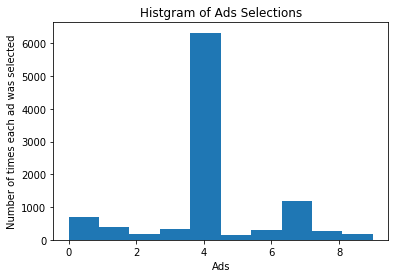

In [39]:
plt.hist(ads_selected)
plt.title('Histgram of Ads Selections')
plt.ylabel('Number of times each ad was selected')
plt.xlabel('Ads')
plt.show()

分析：

1. 从 dataset 上的 describe 信息我们也可以得知 4 的期望是最大的。所以 ad 4 被选中的次数是最多的。
2. UCB 算法是一个确定性的算法 (deterministic algorithm)，无论我们运行多少次，其结果都是固定的。

接下来我们讨论的 Thompson Sampling 算法是一个概率算法。

